# MovieLens 10M Dataset
姓名：廖嘉琦

学号：1120200733

## Step 0 导入相关库
包括pandas，matplotlib，seaborn，并设置matplotlib的中文字体。

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## Step 1 读入数据
从`*.dat`中读入数据，解析后存入对应的`pandas`的`DataFrame`中。

1. 读入`movies.dat`，包括`MovieID::Title::Genres`，将`Genres`拆分为多列，并从`Title`中解析出`Year`。

In [22]:
dtype_spec = {
    'MovieID': int,
    'Title': str
}

# MovieID::Title::Genres
movies_df = pd.read_csv('movies.dat', sep='::', engine='python', header=None,
                        names=['MovieID', 'Title', 'Genres'],
                        dtype=dtype_spec)

# split Genres by '|'
movies_df['Genres'] = movies_df['Genres'].apply(lambda x: x.split('|'))
movies_df['Year'] = movies_df['Title'].apply(
    lambda x: int(x[-5:-1]) if x[-5:-1].isdigit() else -1)
movies_df['Title'] = movies_df['Title'].apply(
    lambda s: s[:-7])
print(movies_df.head())

   MovieID                        Title  \
0        1                    Toy Story   
1        2                      Jumanji   
2        3             Grumpier Old Men   
3        4            Waiting to Exhale   
4        5  Father of the Bride Part II   

                                              Genres  Year  
0  [Adventure, Animation, Children, Comedy, Fantasy]  1995  
1                     [Adventure, Children, Fantasy]  1995  
2                                  [Comedy, Romance]  1995  
3                           [Comedy, Drama, Romance]  1995  
4                                           [Comedy]  1995  


2. 读入`ratings.dat`，包括`UserID::MovieID::Rating::Timestamp`，将`Timestamp`转换为`Datetime`格式。

In [23]:
dtype_spec = {
    'UserID': int,
    'MovieID': int,
    'Rating': float
}

# UserID::MovieID::Rating::Timestamp
ratings_df = pd.read_csv('ratings.dat', sep='::', engine='python',
                         names=['UserID', 'MovieID', 'Rating', 'Timestamp'],
                         dtype=dtype_spec)

# convert Timestamp to datetime
ratings_df['Timestamp'] = pd.to_datetime(ratings_df['Timestamp'], unit='s')

print(ratings_df.head())

   UserID  MovieID  Rating           Timestamp
0       1      122     5.0 1996-08-02 11:24:06
1       1      185     5.0 1996-08-02 10:58:45
2       1      231     5.0 1996-08-02 10:56:32
3       1      292     5.0 1996-08-02 10:57:01
4       1      316     5.0 1996-08-02 10:56:32


In [24]:
dtype_spec = {
    'UserID': int,
    'MovieID': int,
    'Tag': str
}

# UserID::MovieID::Tag::Timestamp
tags_df = pd.read_csv('tags.dat', sep='::', engine='python',
                         names=['UserID', 'MovieID', 'Tag', 'Timestamp'],
                         dtype=dtype_spec)

# convert Timestamp to datetime
tags_df['Timestamp'] = pd.to_datetime(tags_df['Timestamp'], unit='s')

print(tags_df.head())

   UserID  MovieID              Tag           Timestamp
0      15     4973       excellent! 2008-07-04 15:17:10
1      20     1747         politics 2007-08-28 01:17:47
2      20     1747           satire 2007-08-28 01:17:47
3      20     2424  chick flick 212 2007-08-28 01:17:15
4      20     2424            hanks 2007-08-28 01:17:15


In [25]:
print('Movie: Num =', len(movies_df))
print('Ratings: Num =', len(ratings_df))
print('Tags: Num =', len(tags_df))

Movie: Num = 10681
Ratings: Num = 10000054
Tags: Num = 95580


此时，得到三个`DataFrame`：
- `movies_df`：电影数据，共10681部。
- `ratings_df`：评分数据，共10000054条。
- `tags_df`：标签数据，共95580条。

# Step 3 分析电影数据
1. 统计电影的上映年份分布
2. 统计电影不同类型的比例
3. 剔除不合法的类型数据

异常年份的电影数量: 0


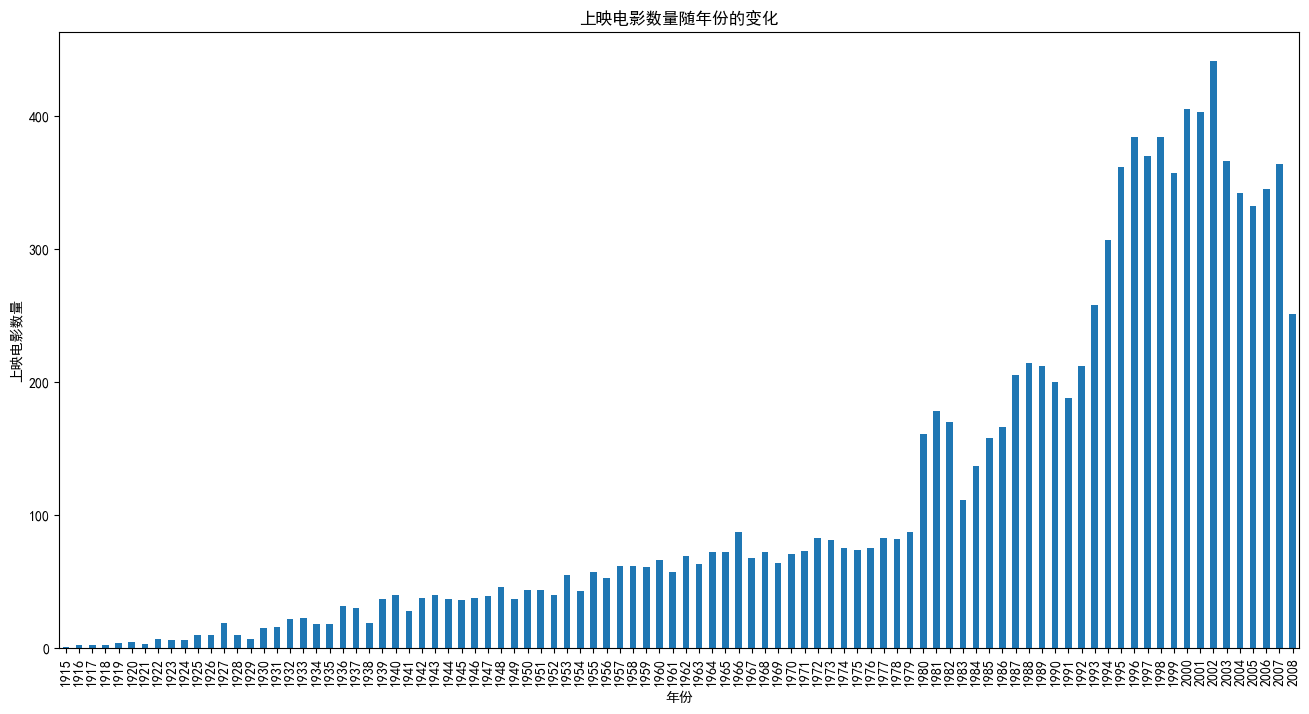

In [26]:
print('异常年份的电影数量:', movies_df[movies_df['Year'] == -1].shape[0])
plt.figure(figsize=(16, 8))
movies_df[movies_df['Year'] != -1]['Year'].value_counts().sort_index().plot(kind='bar')
plt.xticks(rotation=90)
plt.xlabel('年份')
plt.ylabel('上映电影数量')
plt.title('上映电影数量随年份的变化');

In [27]:
genres = {'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary',
          'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
          'Thriller', 'War', 'Western'}

movies_df['NonStandardGenres'] = movies_df['Genres'].apply(
    lambda x: [genre for genre in x if genre not in genres])

non_standard_genres_movies = movies_df[movies_df['NonStandardGenres'].apply(
    len) > 0].drop('Genres', axis=1)
print(non_standard_genres_movies.head())
print('去除异常分类:', len(non_standard_genres_movies))
movies_df = movies_df.assign(Genres=lambda df: df['Genres'].apply(lambda x: [
                             genre for genre in x if genre in genres])).drop('NonStandardGenres', axis=1)

      MovieID                   Title  Year NonStandardGenres
32         33        Wings of Courage  1995            [IMAX]
36         37  Across the Sea of Time  1995            [IMAX]
1724     1797                 Everest  1998            [IMAX]
3074     3159           Fantasia 2000  1999            [IMAX]
4289     4382                  Wolves  1999            [IMAX]
去除异常分类: 30


接下来分析不同分类的电影的数量和占比。
如果同一个电影有多个分类，那么会统计多次。

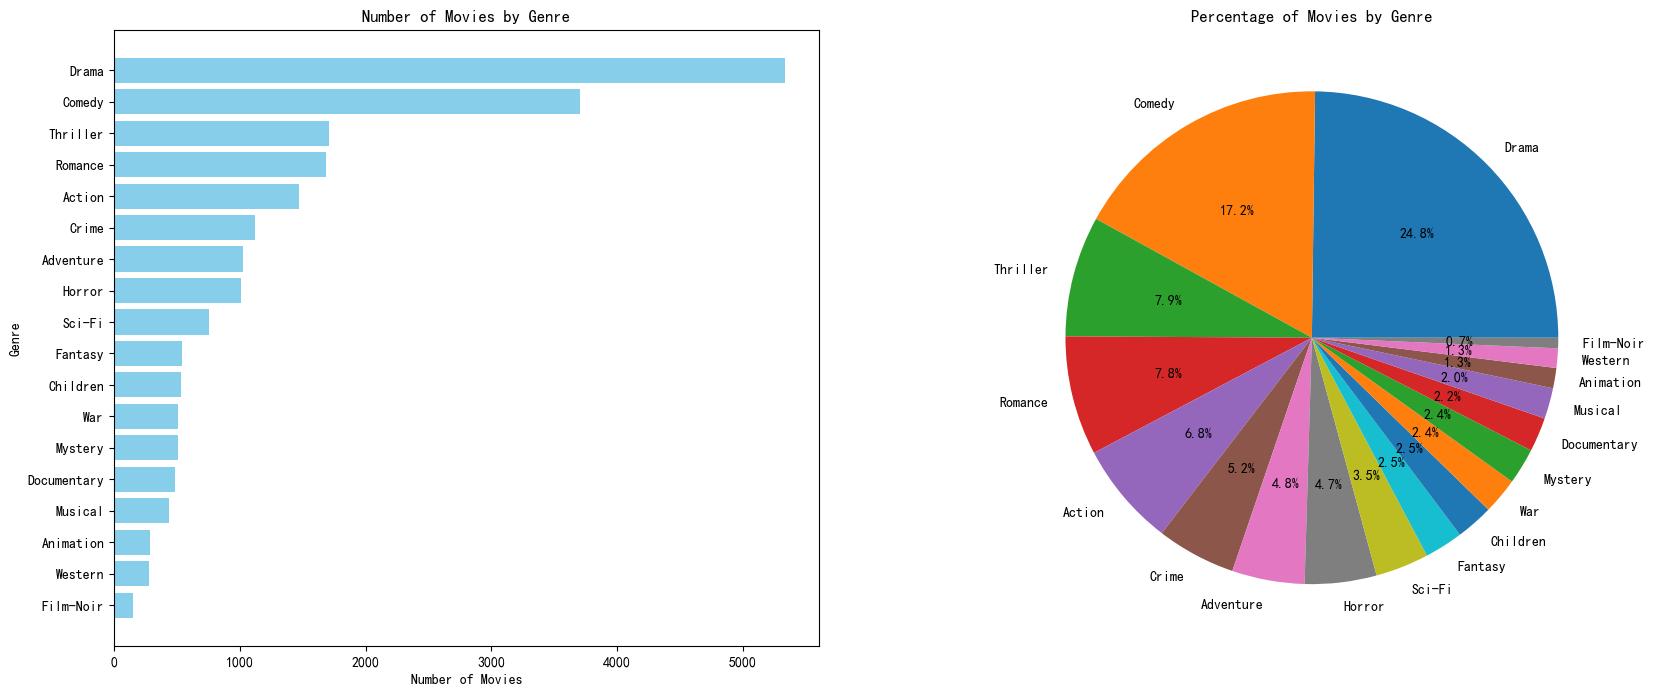

In [28]:
from collections import Counter
genre_counts = Counter([genre for genres in movies_df['Genres']
                       for genre in genres])
genre_counts_df = pd.DataFrame(list(genre_counts.items()), columns=[
                               'Genre', 'Count']).sort_values('Count', ascending=False)

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.barh(genre_counts_df['Genre'], genre_counts_df['Count'], color='skyblue')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.title('Number of Movies by Genre')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.pie(genre_counts_df['Count'],
        labels=genre_counts_df['Genre'], autopct='%1.1f%%')
plt.title('Percentage of Movies by Genre');

## Step 4 分析评分数据
先统计评分数量的时间分布。

In [29]:
ratings_df['Year'] = pd.to_datetime(ratings_df['Timestamp'], unit='s').dt.year
yearly_review_count = ratings_df.groupby(
    'Year')['Rating'].count().reset_index()
print(yearly_review_count)
ratings_df = ratings_df[~ratings_df['Year'].isin([1995, 2009])]

    Year   Rating
0   1995        3
1   1996  1047618
2   1997   459947
3   1998   202092
4   1999   788793
5   2000  1271623
6   2001   759141
7   2002   583409
8   2003   688694
9   2004   768168
10  2005  1177283
11  2006   765733
12  2007   699325
13  2008   773617
14  2009    14608


发现1995年和2009年的评分数据显著少于其他年份，可能是数据缺失，因此剔除这两年的数据。

接下来统计不同分类的电影的评分和评价数量，以及其随着时间的变化。

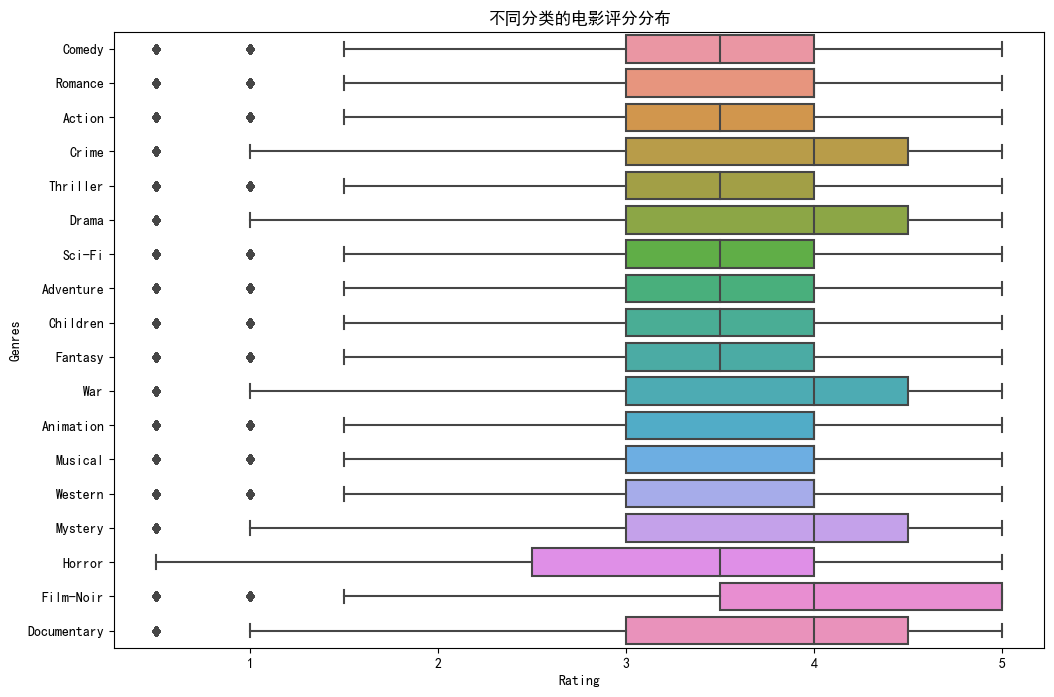

In [30]:
movies_df_exploded = movies_df.explode('Genres')
merged_df = pd.merge(ratings_df, movies_df_exploded, on='MovieID')

plt.figure(figsize=(12, 8))
sns.boxplot(x='Rating', y='Genres', data=merged_df)
plt.title('不同分类的电影评分分布');

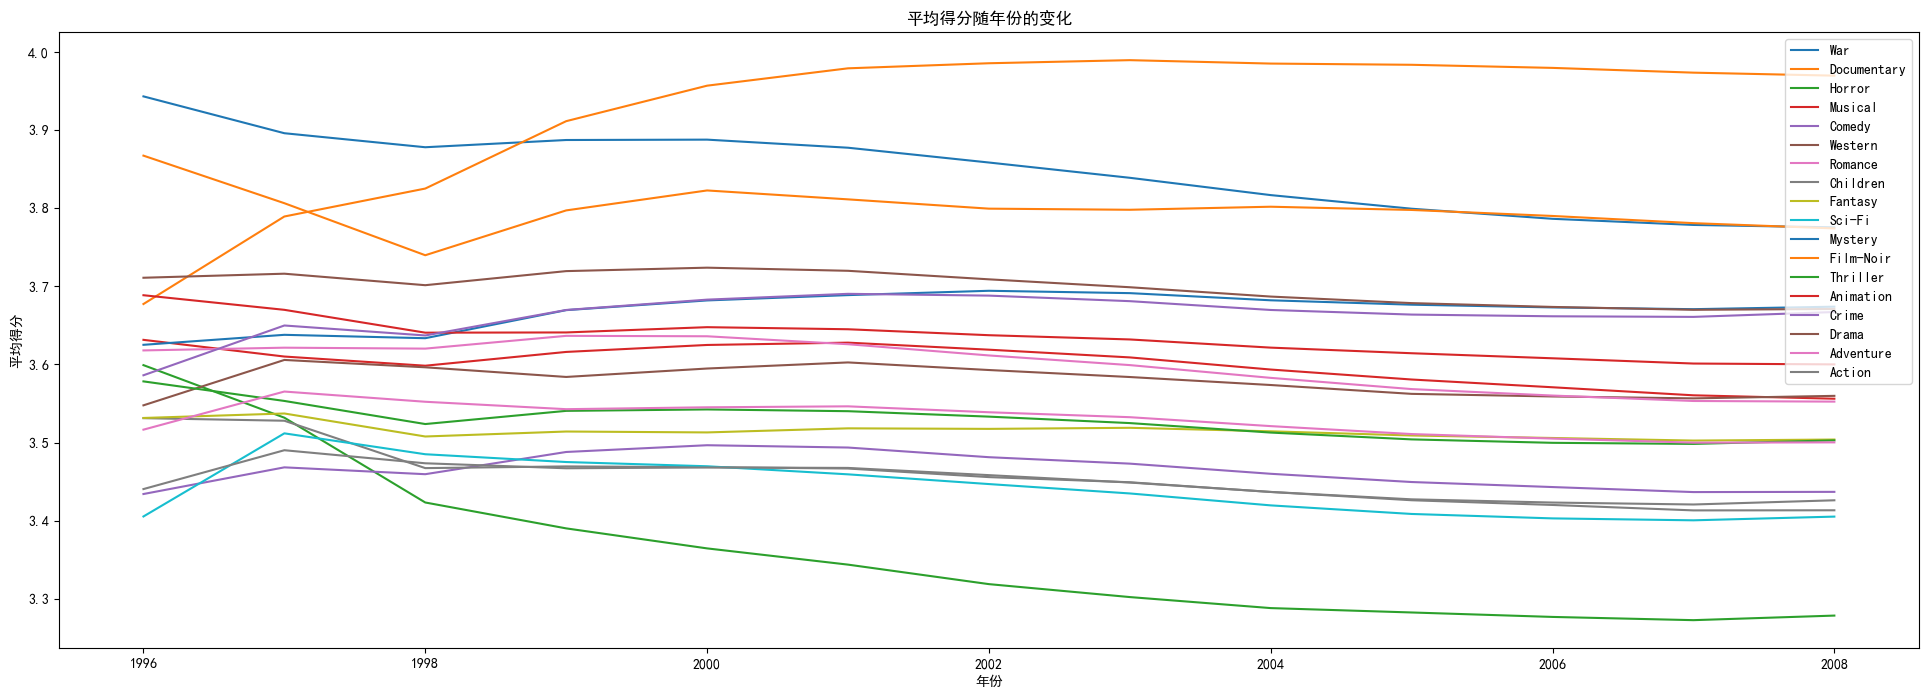

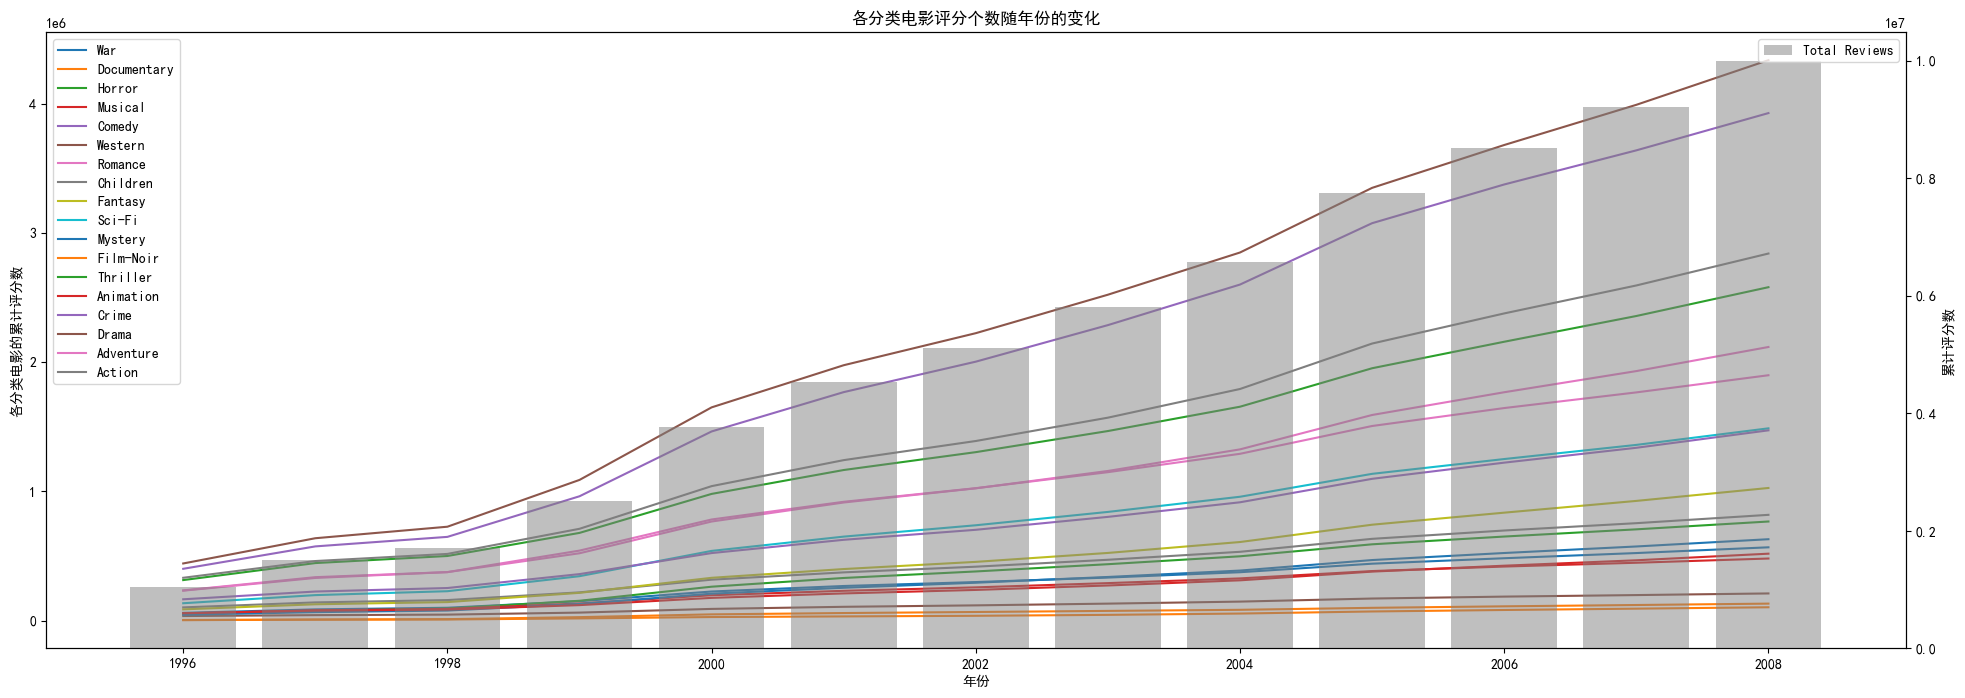

In [31]:
movies_df_exploded = movies_df.explode('Genres')
merged_df = pd.merge(ratings_df, movies_df_exploded, on='MovieID')

average_ratings_per_year = merged_df.groupby(
    ['Genres', 'Year_x'])['Rating'].mean().reset_index()

average_ratings_per_year['Cumulative Average Rating'] = average_ratings_per_year.groupby(
    'Genres')['Rating'].apply(lambda x: x.expanding().mean()).reset_index(level=0, drop=True)

average_ratings_per_year['Yearly Review Count'] = merged_df.groupby(
    ['Genres', 'Year_x'])['Rating'].count().reset_index(drop=True)

average_ratings_per_year['Cumulative Review Count'] = average_ratings_per_year.groupby(
    'Genres')['Yearly Review Count'].cumsum()

average_ratings_per_year = average_ratings_per_year[[
    'Genres', 'Year_x', 'Rating', 'Cumulative Average Rating', 'Yearly Review Count', 'Cumulative Review Count']]

yearly_review_count = ratings_df.groupby(
    'Year')['Rating'].count().reset_index()

yearly_review_count['Cumulative Review Count'] = yearly_review_count['Rating'].cumsum()

plt.figure(figsize=(24, 8))

for genre in genres:
    genre_data = average_ratings_per_year[average_ratings_per_year['Genres'] == genre]
    plt.plot(genre_data['Year_x'],
             genre_data['Cumulative Average Rating'], label=genre)

plt.xlabel('年份')
plt.ylabel('平均得分')
plt.title('平均得分随年份的变化')
plt.legend()

plt.figure(figsize=(24, 8))
ax1 = plt.gca()
for genre in genres:
    genre_data = average_ratings_per_year[average_ratings_per_year['Genres'] == genre]
    ax1.plot(genre_data['Year_x'],
             genre_data['Cumulative Review Count'], label=genre)

ax1.set_xlabel('年份')
ax1.set_ylabel('各分类电影的累计评分数')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.bar(yearly_review_count['Year'], yearly_review_count['Cumulative Review Count'],
        color='grey', alpha=0.5, label='Total Reviews')
ax2.set_ylabel('累计评分数')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

plt.title('各分类电影评分个数随年份的变化');

## Step 5 分析标签数据

先分析标签数随着时间的变化。

   Year    Tag
0  2005     38
1  2006  36163
2  2007  36395
3  2008  22658
4  2009    310


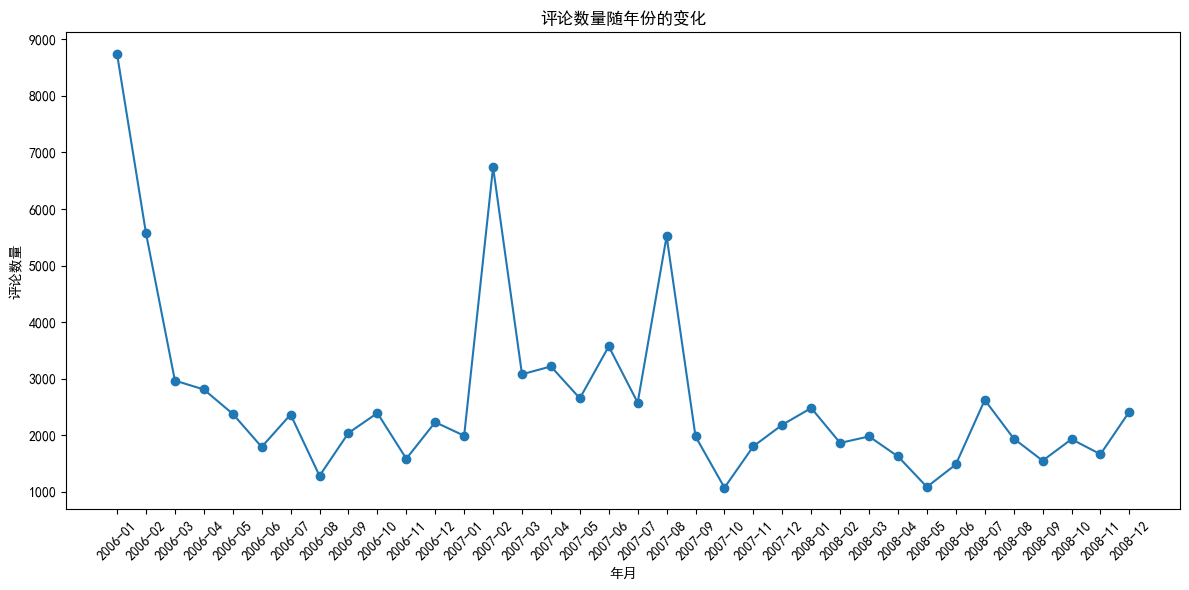

In [32]:
tags_df['Year'] = pd.to_datetime(tags_df['Timestamp'], unit='s').dt.year
yearly_tag_count = tags_df.groupby(
    'Year')['Tag'].count().reset_index()
print(yearly_tag_count)
tags_df = tags_df[~tags_df['Year'].isin([2005, 2009])]
# plot
tags_df['YearMonth'] = pd.to_datetime(
    tags_df['Timestamp'], unit='s').dt.to_period('M')
yearly_monthly_tag_count = tags_df.groupby(
    'YearMonth')['Tag'].count().reset_index(name='Count')
plt.figure(figsize=(12, 6))
plt.plot(yearly_monthly_tag_count['YearMonth'].astype(
    str), yearly_monthly_tag_count['Count'], marker='o')
plt.title('评论数量随年份的变化')
plt.xlabel('年月')
plt.ylabel('评论数量')
plt.xticks(rotation=45)
plt.tight_layout();

发现2005年和2009年只有极少数标签，属于异常数据，剔除。

再分析不同分类的电影的标签数量和占比。

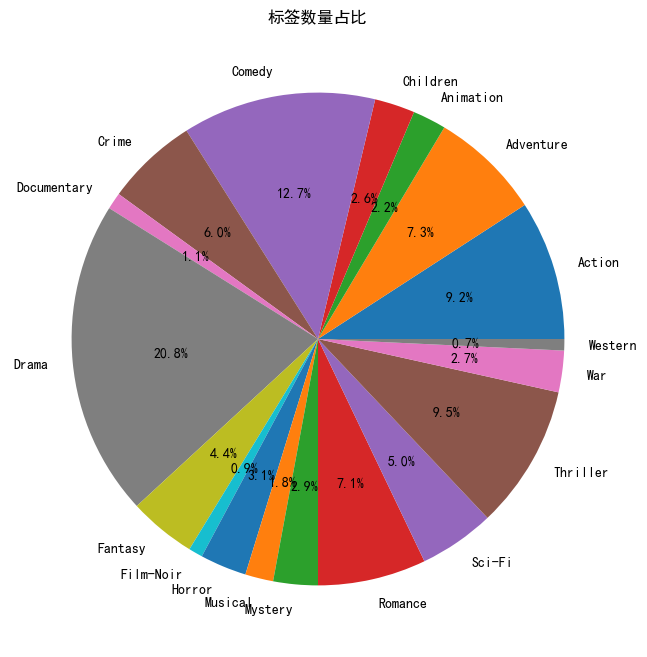

In [36]:
movies_df_exploded = movies_df.explode('Genres')
merged_df = pd.merge(tags_df, movies_df_exploded, on='MovieID')

genre_tag_counts = merged_df.groupby(
    'Genres')['Tag'].count().reset_index(name='Tag Count')

total_tags = genre_tag_counts['Tag Count'].sum()

genre_tag_counts['Proportion'] = genre_tag_counts['Tag Count'] / total_tags

plt.figure(figsize=(10, 8))
plt.pie(genre_tag_counts['Proportion'], labels=genre_tag_counts['Genres'], autopct='%1.1f%%')
plt.title('标签数量占比');